#  CE-40959: Deep Learning

## Homework 5 - 2:  EBGAN

The goal is to train a GAN with an auto-encoder as its discriminator.
For further information read the [paper of EBGAN](https://arxiv.org/abs/1609.03126).

Good luck

In [0]:
import numpy as np

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [16]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

0it [00:00, ?it/s]

9920512it [00:02, 3972898.43it/s]                             


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 67655.33it/s]                            
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1258901.64it/s]                           
0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 25438.45it/s]            

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
CUDA = True
BATCH_SIZE = 64

In [0]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def show(image_batch, rows=1):
    # Set Plot dimensions
    cols = np.ceil(image_batch.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (0.0 + cols, 0.0 + rows) # set default size of plots
    
    for i in range(image_batch.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

---

In [21]:
import torch
import torch.nn as nn

loss =   nn.MSELoss(reduction='none') 
                  
                
input = torch.randn(3, 5)
target = torch.randn(3, 5)
output = torch.mean(loss(input, target),dim=(1))
print(output)

tensor([2.0667, 2.8069, 3.1589])


In [0]:
class AutoEncoderMSE(nn.Module):
    def __init__(self, input_dim, encoder_dims, decoder_dims, dropout_rate=0.5):
        super(AutoEncoderMSE, self).__init__()
        
        self.input_dim = input_dim
        ########################## TODO ##########################
        # self.input_dropout must be a dropout module with p=dropout_rate
        self.input_dropout = nn.Dropout(p=dropout_rate)
        ######################## END TODO ########################
        
        
        # Encoder part
        encoder_layers = []
        ########################## TODO ##########################
        # Define encoder layers and add them to `encoder_layers`
        # Use nn.LeakyReLU(0.2) for activation functions
        last_layer_dim=input_dim
        for encoder_dim in encoder_dims:
          encoder_layers.append(nn.Linear(last_layer_dim,encoder_dim,bias=True))
          encoder_layers.append(nn.LeakyReLU(0.2))
          last_layer_dim=encoder_dim
        ######################## END TODO ########################
        self.encoder = nn.Sequential(*encoder_layers)
        
        last_encoder_dim = ([input_dim] + encoder_dims)[-1]

        # Decoder part
        decoder_layers = []
        ########################## TODO ##########################
        # Define decoder layers and add them to `decoder_layers`
        # Use nn.LeakyReLU(0.2) for activation functions
        # Last layer does not need any activation function
        
        for decoder_dim in decoder_dims:
          decoder_layers.append(nn.Linear(last_layer_dim,decoder_dim,bias=True))
          decoder_layers.append(nn.LeakyReLU(0.2))
          last_layer_dim=decoder_dim
        
        decoder_layers.append(nn.Linear(last_layer_dim,input_dim,bias=True))
        
        ######################## END TODO ########################
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.MSE = nn.MSELoss(reduction='none')

    def forward(self, x):
        ########################## TODO ##########################
        # Complete the flow
        # x > dropout > encoder > h > decoder > output > mse
        # Note that mse.shape = (batch_size, )
        # DO NOT FORGET TO ADD DROPOUT LAYER
        
        x_drop_outed = self.input_dropout(x)
        x_encoded = self.encoder(x_drop_outed)
        x_recon=self.decoder(x_encoded)
        
        return {"mse":torch.mean(self.MSE(x,x_recon),dim=(1))}
        ######################## END TODO ########################

      
discriminator = AutoEncoderMSE(784, [256, 128, 64], [128, 256], dropout_rate=0.5)

In [0]:
generator = nn.Sequential(
    nn.Linear(128, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.Dropout(),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 784),
    nn.Sigmoid()
)

In [0]:
if CUDA:
  discriminator.cuda()
  generator.cuda()

In [0]:
#LEARNING_RATE_D = 0.0002
#LEARNING_RATE_G = 0.0002

LEARNING_RATE_D = 0.0002
LEARNING_RATE_G = 0.0002


opt_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D)
opt_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G)

In [0]:
N_EPOCH = 100

In [55]:
print(discriminator)

AutoEncoderMSE(
  (input_dropout): Dropout(p=0.5)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=784, bias=True)
  )
  (MSE): MSELoss()
)


epoch: 0 	 last batch loss D: 14.61003589630127 	 last batch loss G: 8.614215850830078


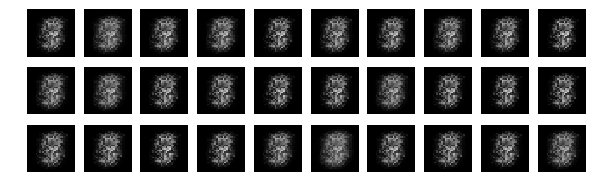

epoch: 1 	 last batch loss D: 5.355498790740967 	 last batch loss G: 24.385631561279297


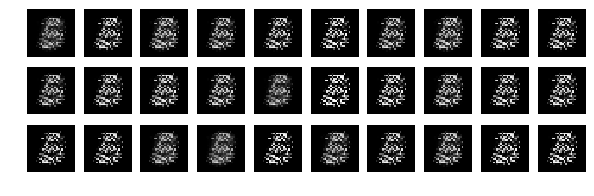

epoch: 2 	 last batch loss D: 1.383496880531311 	 last batch loss G: 31.01516342163086


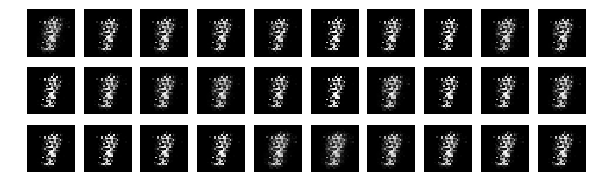

epoch: 3 	 last batch loss D: 0.23882125318050385 	 last batch loss G: 35.194129943847656


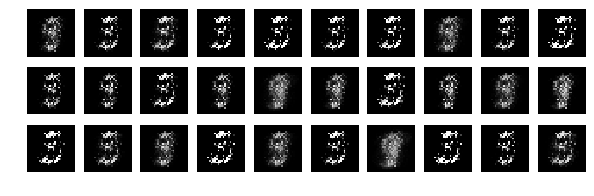

epoch: 4 	 last batch loss D: 0.7233560085296631 	 last batch loss G: 21.551128387451172


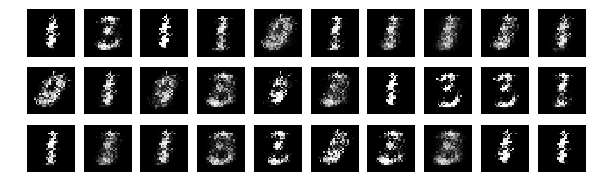

epoch: 5 	 last batch loss D: 2.2131433486938477 	 last batch loss G: 20.72136688232422


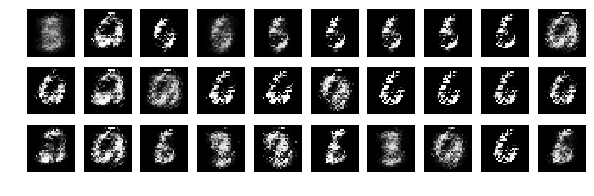

epoch: 6 	 last batch loss D: 4.957415580749512 	 last batch loss G: 17.628456115722656


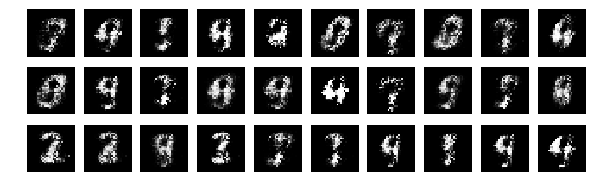

epoch: 7 	 last batch loss D: 2.9477343559265137 	 last batch loss G: 17.058500289916992


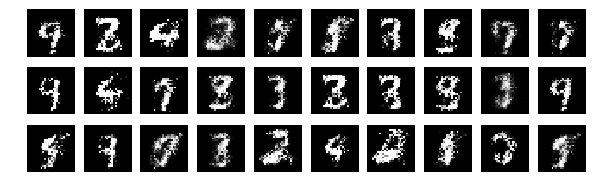

epoch: 8 	 last batch loss D: 4.140369415283203 	 last batch loss G: 18.23069953918457


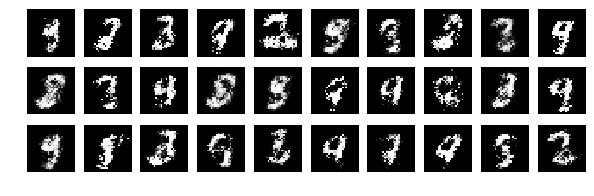

epoch: 9 	 last batch loss D: 4.79969596862793 	 last batch loss G: 15.592437744140625


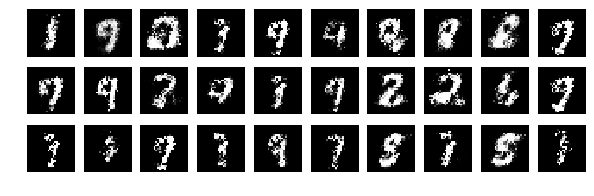

epoch: 10 	 last batch loss D: 3.2403836250305176 	 last batch loss G: 15.59995174407959


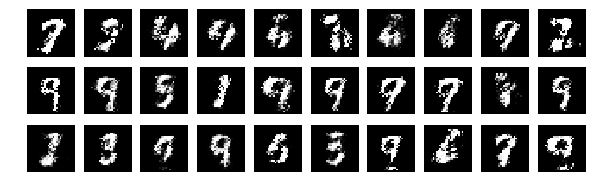

epoch: 11 	 last batch loss D: 5.023954391479492 	 last batch loss G: 15.267297744750977


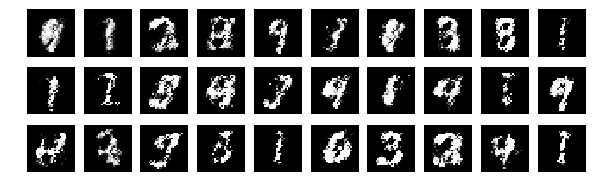

epoch: 12 	 last batch loss D: 5.381539821624756 	 last batch loss G: 15.012124061584473


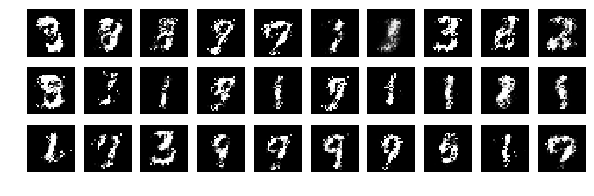

epoch: 13 	 last batch loss D: 5.5630598068237305 	 last batch loss G: 18.819580078125


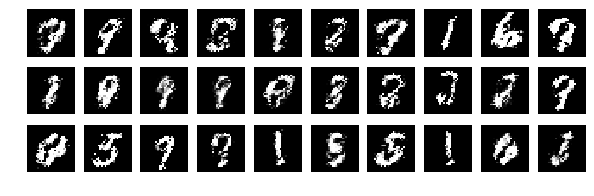

epoch: 14 	 last batch loss D: 5.731198310852051 	 last batch loss G: 13.683377265930176


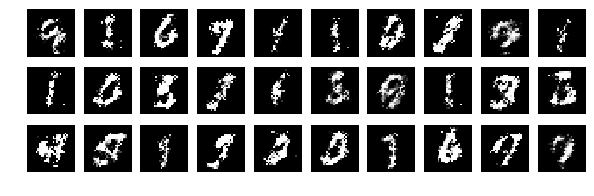

epoch: 15 	 last batch loss D: 7.644040107727051 	 last batch loss G: 14.943267822265625


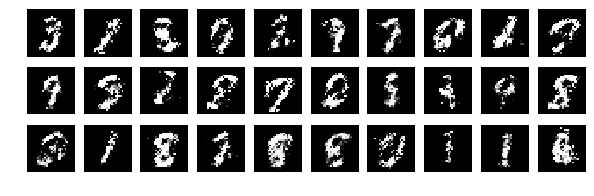

epoch: 16 	 last batch loss D: 3.7340328693389893 	 last batch loss G: 14.381956100463867


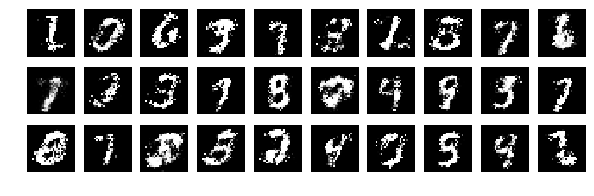

epoch: 17 	 last batch loss D: 6.244199752807617 	 last batch loss G: 13.970222473144531


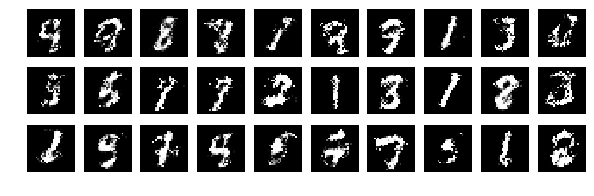

epoch: 18 	 last batch loss D: 4.998506546020508 	 last batch loss G: 15.428801536560059


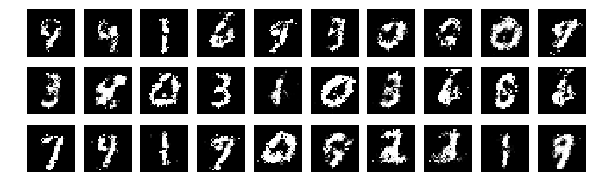

epoch: 19 	 last batch loss D: 3.792222023010254 	 last batch loss G: 12.728986740112305


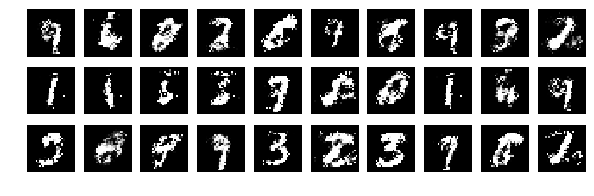

epoch: 20 	 last batch loss D: 4.992012977600098 	 last batch loss G: 14.174165725708008


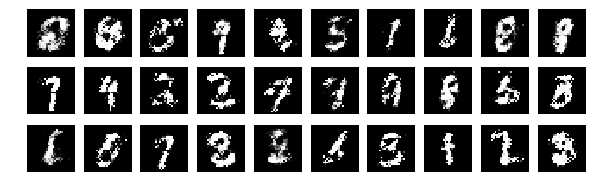

epoch: 21 	 last batch loss D: 8.465970039367676 	 last batch loss G: 14.154823303222656


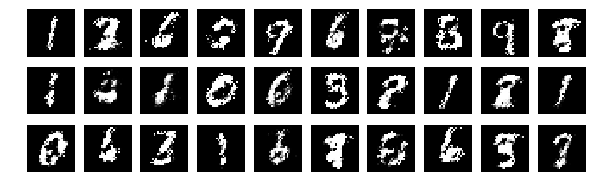

epoch: 22 	 last batch loss D: 5.159970283508301 	 last batch loss G: 15.5118989944458


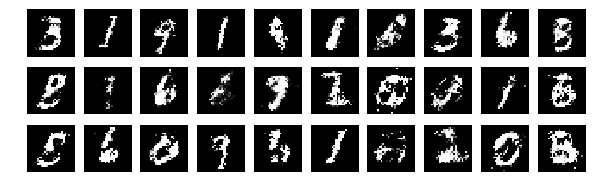

epoch: 23 	 last batch loss D: 3.435349225997925 	 last batch loss G: 14.955469131469727


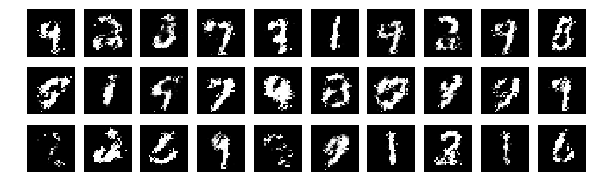

epoch: 24 	 last batch loss D: 5.520965576171875 	 last batch loss G: 14.737375259399414


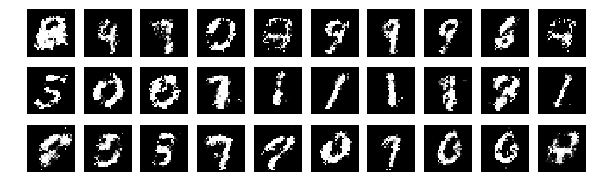

epoch: 25 	 last batch loss D: 9.170446395874023 	 last batch loss G: 12.966743469238281


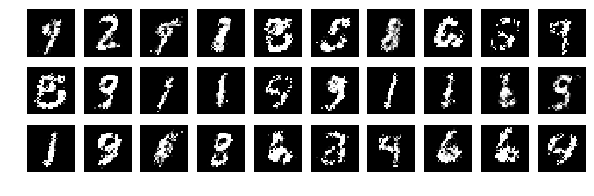

epoch: 26 	 last batch loss D: 5.025516510009766 	 last batch loss G: 15.774679183959961


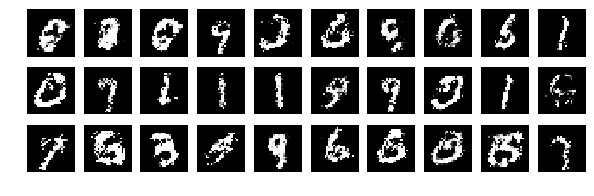

epoch: 27 	 last batch loss D: 6.725842475891113 	 last batch loss G: 13.057422637939453


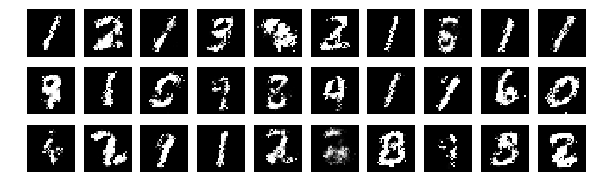

epoch: 28 	 last batch loss D: 6.962362289428711 	 last batch loss G: 12.65821647644043


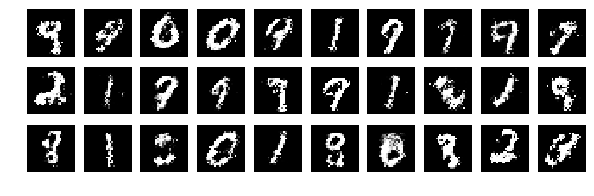

epoch: 29 	 last batch loss D: 8.465271949768066 	 last batch loss G: 11.031450271606445


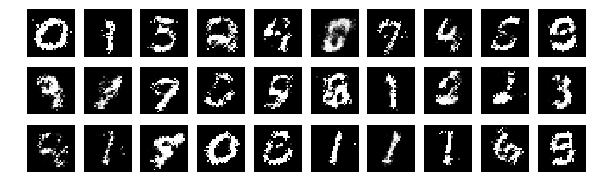

epoch: 30 	 last batch loss D: 5.86758279800415 	 last batch loss G: 11.651899337768555


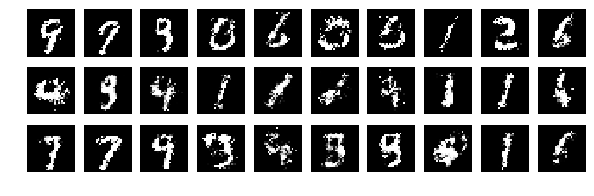

epoch: 31 	 last batch loss D: 5.1319475173950195 	 last batch loss G: 14.740053176879883


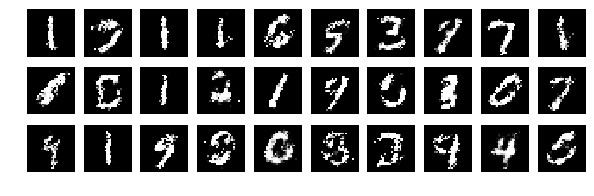

epoch: 32 	 last batch loss D: 7.788730621337891 	 last batch loss G: 12.921256065368652


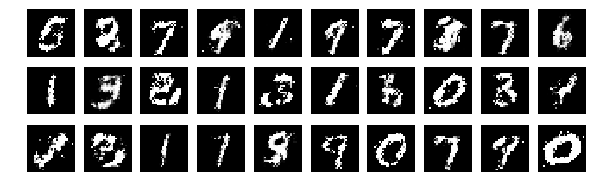

epoch: 33 	 last batch loss D: 9.74860954284668 	 last batch loss G: 12.819443702697754


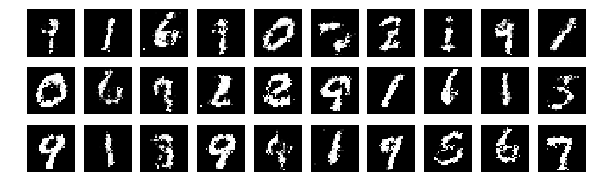

epoch: 34 	 last batch loss D: 3.802515983581543 	 last batch loss G: 15.854513168334961


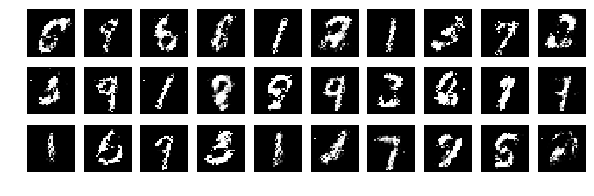

epoch: 35 	 last batch loss D: 7.252402305603027 	 last batch loss G: 14.13540267944336


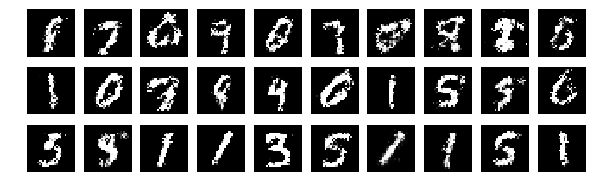

epoch: 36 	 last batch loss D: 5.905087471008301 	 last batch loss G: 13.893880844116211


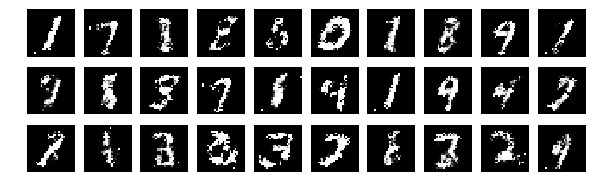

epoch: 37 	 last batch loss D: 7.290116786956787 	 last batch loss G: 13.233595848083496


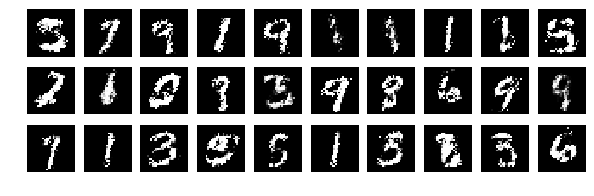

epoch: 38 	 last batch loss D: 7.007772445678711 	 last batch loss G: 12.918500900268555


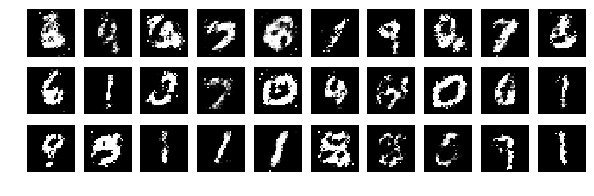

epoch: 39 	 last batch loss D: 6.464316368103027 	 last batch loss G: 15.16551399230957


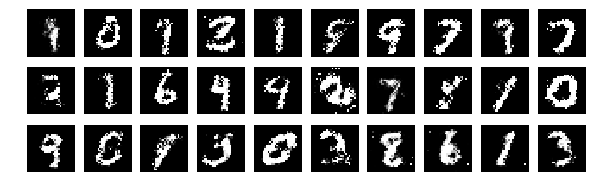

epoch: 40 	 last batch loss D: 6.560483932495117 	 last batch loss G: 13.646477699279785


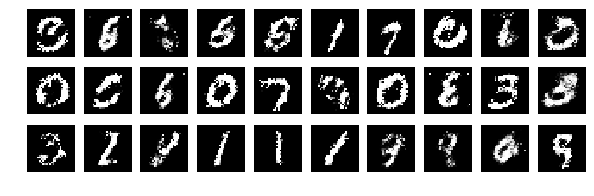

epoch: 41 	 last batch loss D: 8.60398006439209 	 last batch loss G: 13.65548324584961


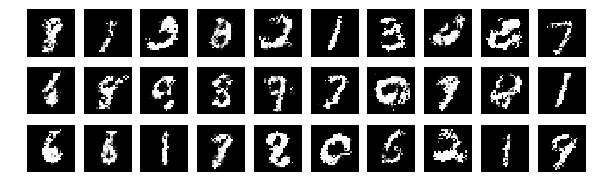

epoch: 42 	 last batch loss D: 7.19710111618042 	 last batch loss G: 13.33606243133545


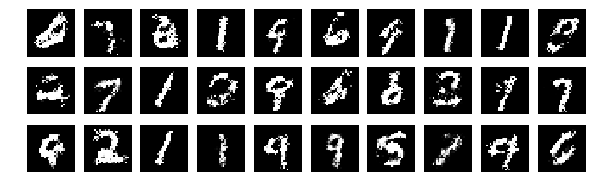

epoch: 43 	 last batch loss D: 6.825440883636475 	 last batch loss G: 13.825347900390625


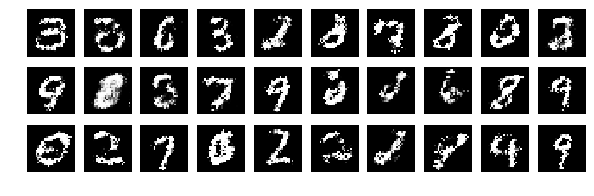

epoch: 44 	 last batch loss D: 7.715633392333984 	 last batch loss G: 14.33636474609375


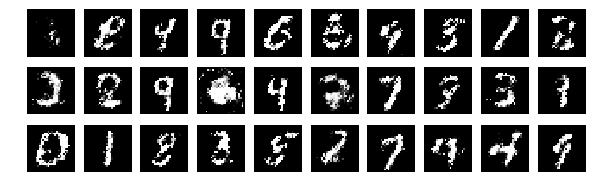

epoch: 45 	 last batch loss D: 7.899117469787598 	 last batch loss G: 13.931185722351074


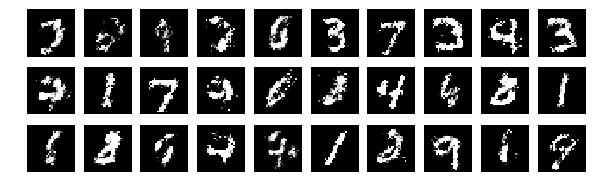

epoch: 46 	 last batch loss D: 4.552985191345215 	 last batch loss G: 14.125728607177734


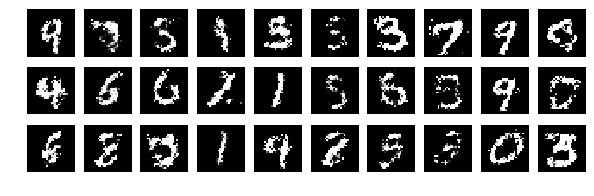

epoch: 47 	 last batch loss D: 6.132355690002441 	 last batch loss G: 15.807767868041992


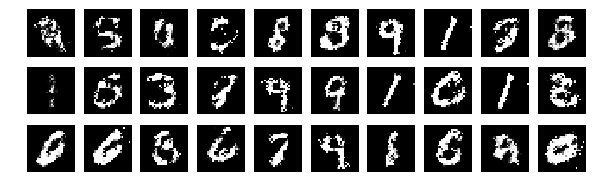

epoch: 48 	 last batch loss D: 6.562064170837402 	 last batch loss G: 15.393924713134766


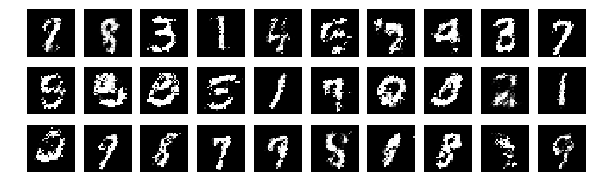

epoch: 49 	 last batch loss D: 9.650785446166992 	 last batch loss G: 13.384117126464844


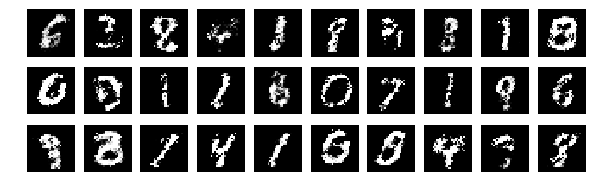

epoch: 50 	 last batch loss D: 7.092946529388428 	 last batch loss G: 13.994117736816406


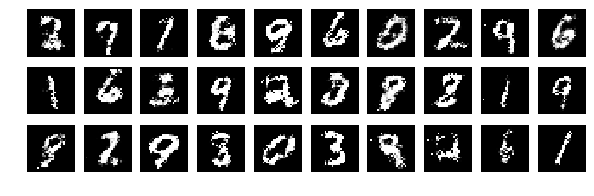

epoch: 51 	 last batch loss D: 8.061306953430176 	 last batch loss G: 10.300549507141113


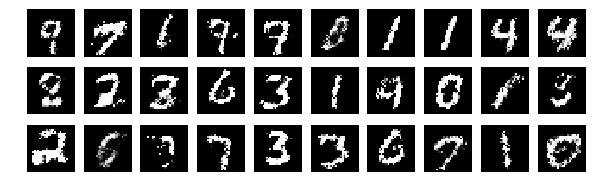

epoch: 52 	 last batch loss D: 10.450879096984863 	 last batch loss G: 11.360024452209473


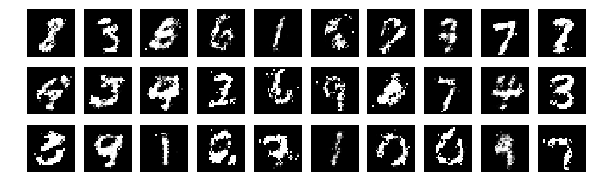

epoch: 53 	 last batch loss D: 8.898427963256836 	 last batch loss G: 13.95986270904541


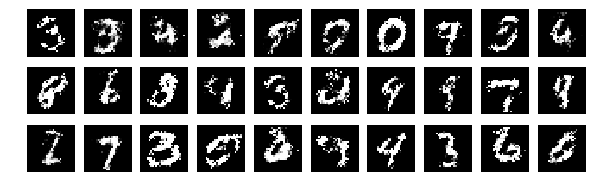

epoch: 54 	 last batch loss D: 8.119611740112305 	 last batch loss G: 12.259913444519043


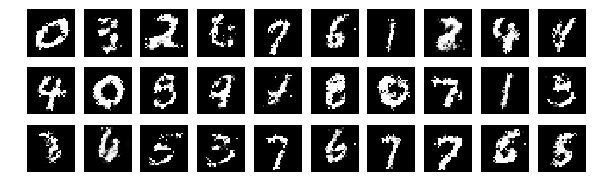

epoch: 55 	 last batch loss D: 12.531608581542969 	 last batch loss G: 13.786554336547852


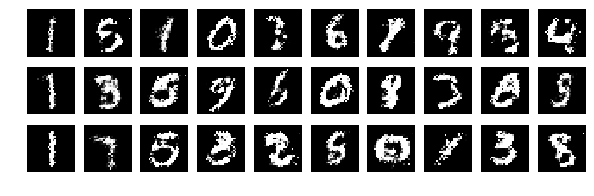

epoch: 56 	 last batch loss D: 9.146449089050293 	 last batch loss G: 10.619428634643555


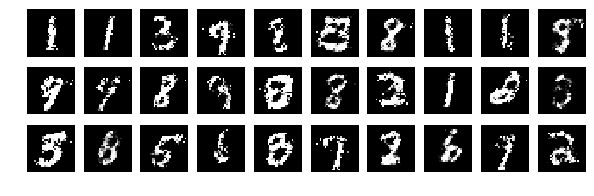

epoch: 57 	 last batch loss D: 5.848373889923096 	 last batch loss G: 14.251914024353027


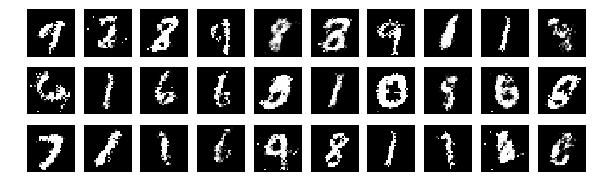

epoch: 58 	 last batch loss D: 8.30169677734375 	 last batch loss G: 11.699272155761719


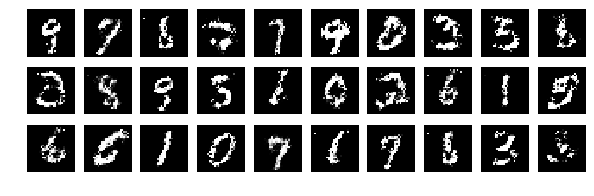

epoch: 59 	 last batch loss D: 7.667759895324707 	 last batch loss G: 13.557095527648926


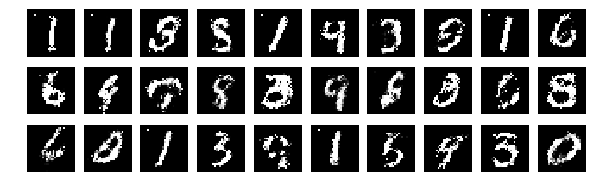

epoch: 60 	 last batch loss D: 6.2619428634643555 	 last batch loss G: 13.427278518676758


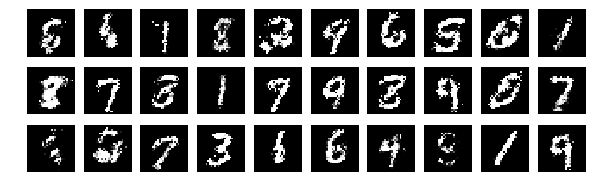

epoch: 61 	 last batch loss D: 8.02169418334961 	 last batch loss G: 14.355646133422852


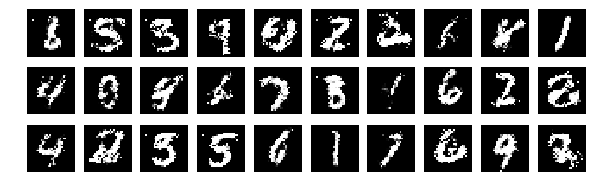

epoch: 62 	 last batch loss D: 7.245841979980469 	 last batch loss G: 13.383068084716797


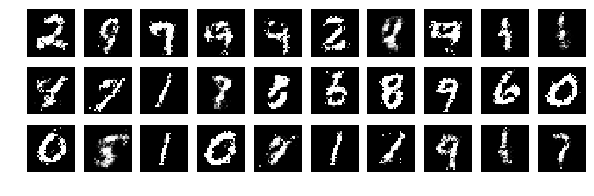

epoch: 63 	 last batch loss D: 11.345705032348633 	 last batch loss G: 11.313514709472656


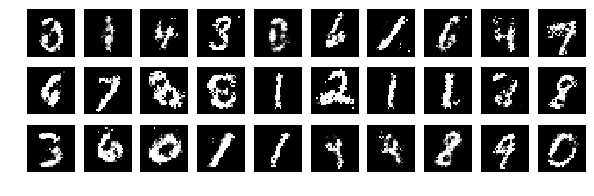

epoch: 64 	 last batch loss D: 8.402379989624023 	 last batch loss G: 14.402981758117676


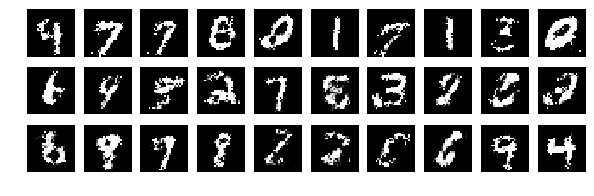

epoch: 65 	 last batch loss D: 7.636770725250244 	 last batch loss G: 12.037834167480469


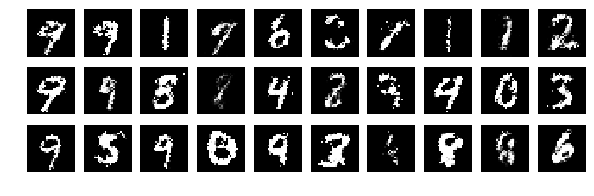

epoch: 66 	 last batch loss D: 8.326582908630371 	 last batch loss G: 14.704033851623535


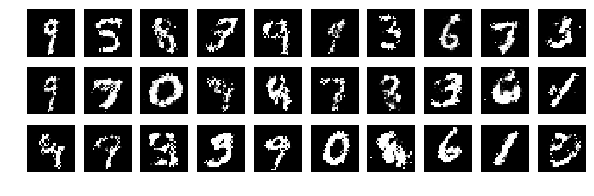

epoch: 67 	 last batch loss D: 6.144204616546631 	 last batch loss G: 13.09375


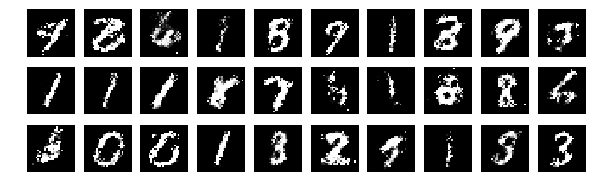

epoch: 68 	 last batch loss D: 8.759528160095215 	 last batch loss G: 13.891142845153809


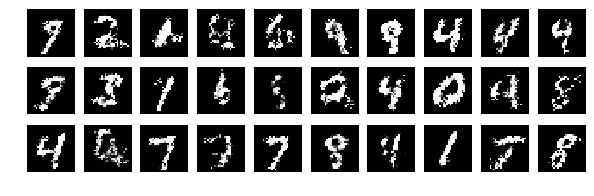

epoch: 69 	 last batch loss D: 6.866984844207764 	 last batch loss G: 13.936399459838867


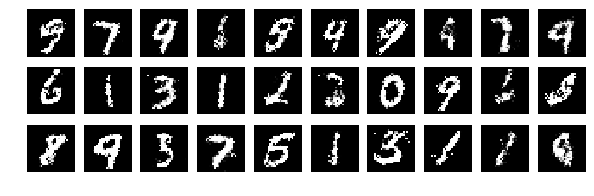

epoch: 70 	 last batch loss D: 8.295415878295898 	 last batch loss G: 12.313314437866211


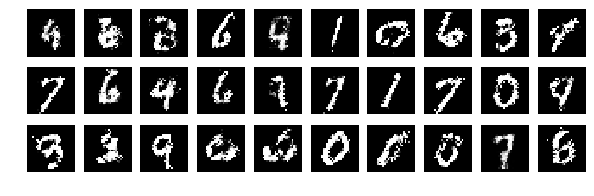

epoch: 71 	 last batch loss D: 6.877817153930664 	 last batch loss G: 12.646785736083984


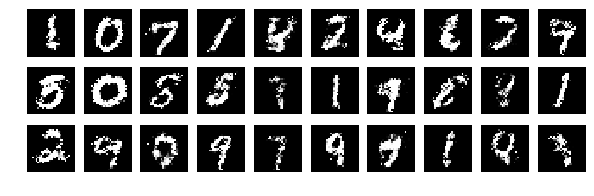

epoch: 72 	 last batch loss D: 7.724363327026367 	 last batch loss G: 12.775738716125488


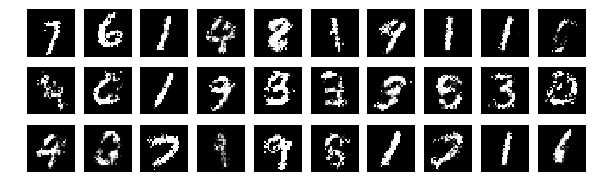

epoch: 73 	 last batch loss D: 6.739953517913818 	 last batch loss G: 12.476920127868652


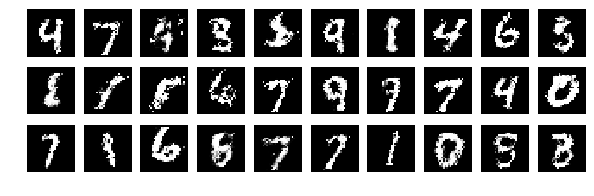

epoch: 74 	 last batch loss D: 7.557977676391602 	 last batch loss G: 11.409187316894531


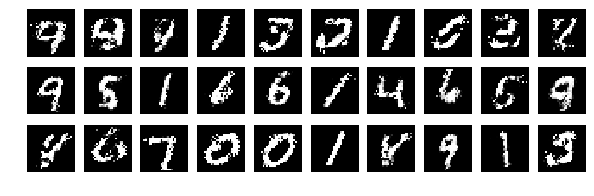

epoch: 75 	 last batch loss D: 7.371852874755859 	 last batch loss G: 13.305624961853027


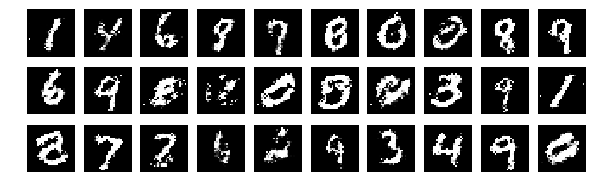

epoch: 76 	 last batch loss D: 11.122529983520508 	 last batch loss G: 12.799434661865234


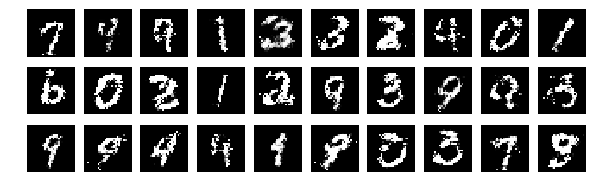

epoch: 77 	 last batch loss D: 9.541009902954102 	 last batch loss G: 12.96017837524414


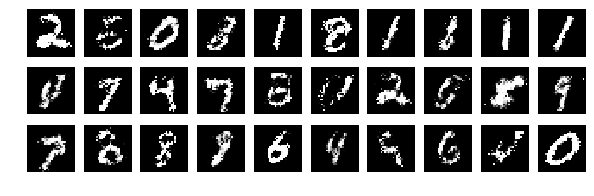

epoch: 78 	 last batch loss D: 13.991800308227539 	 last batch loss G: 10.03801155090332


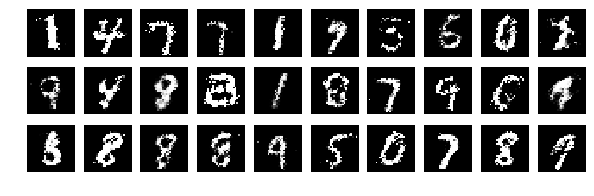

epoch: 79 	 last batch loss D: 7.778698444366455 	 last batch loss G: 12.621736526489258


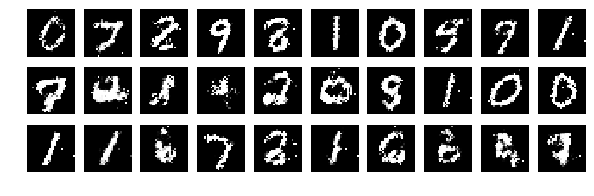

epoch: 80 	 last batch loss D: 8.285423278808594 	 last batch loss G: 11.165349006652832


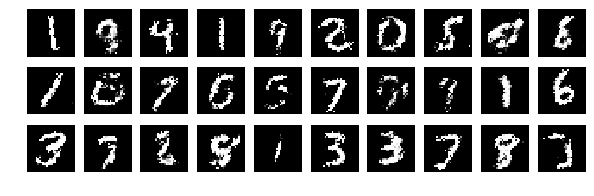

epoch: 81 	 last batch loss D: 7.11729621887207 	 last batch loss G: 13.930099487304688


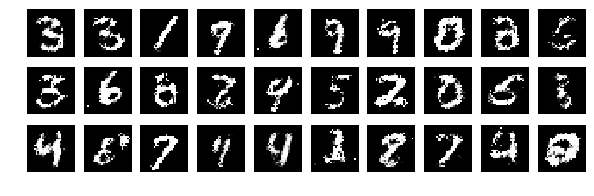

epoch: 82 	 last batch loss D: 9.522181510925293 	 last batch loss G: 12.897821426391602


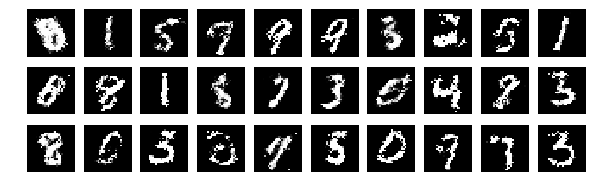

epoch: 83 	 last batch loss D: 8.479880332946777 	 last batch loss G: 12.368438720703125


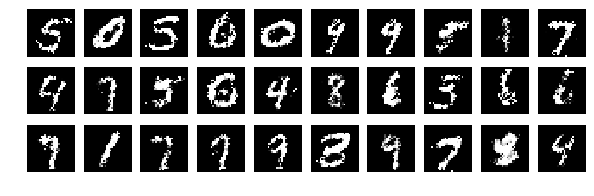

epoch: 84 	 last batch loss D: 8.750129699707031 	 last batch loss G: 11.342550277709961


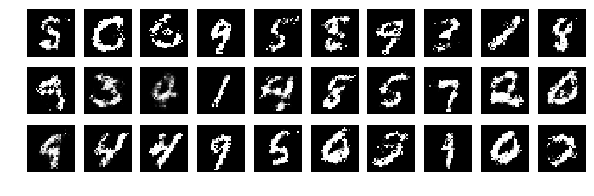

epoch: 85 	 last batch loss D: 8.78505802154541 	 last batch loss G: 12.44329833984375


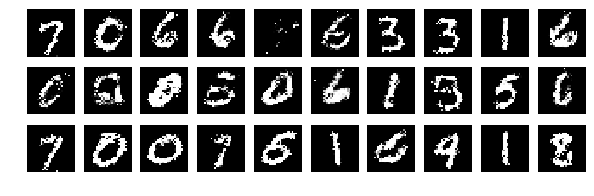

epoch: 86 	 last batch loss D: 7.877485275268555 	 last batch loss G: 12.592864990234375


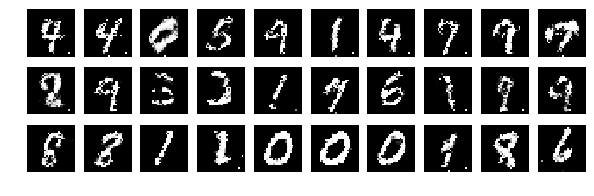

epoch: 87 	 last batch loss D: 9.222908020019531 	 last batch loss G: 12.802902221679688


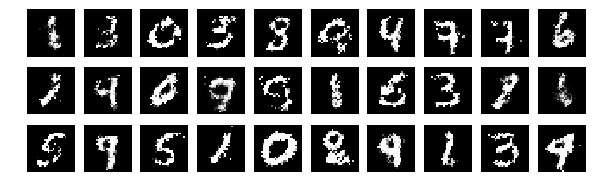

epoch: 88 	 last batch loss D: 11.201301574707031 	 last batch loss G: 11.51800537109375


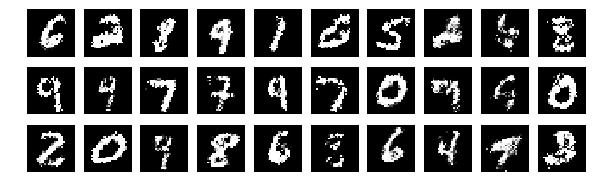

epoch: 89 	 last batch loss D: 9.495068550109863 	 last batch loss G: 12.46428108215332


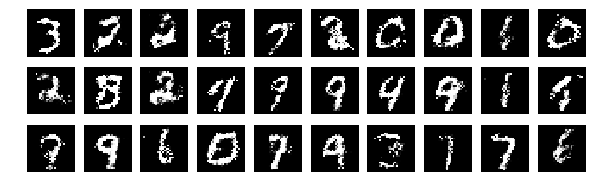

epoch: 90 	 last batch loss D: 10.107044219970703 	 last batch loss G: 8.179004669189453


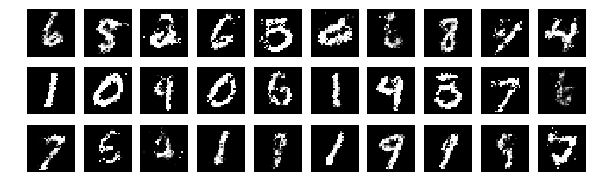

epoch: 91 	 last batch loss D: 9.493377685546875 	 last batch loss G: 11.024986267089844


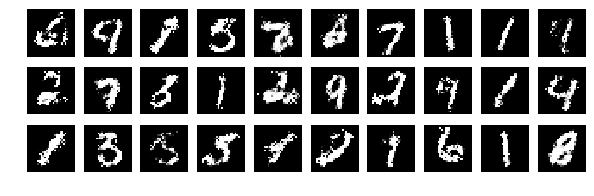

epoch: 92 	 last batch loss D: 7.193779468536377 	 last batch loss G: 12.131263732910156


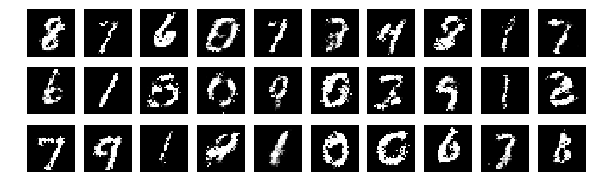

epoch: 93 	 last batch loss D: 8.788837432861328 	 last batch loss G: 11.679654121398926


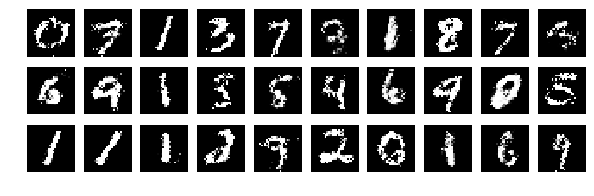

epoch: 94 	 last batch loss D: 7.897374153137207 	 last batch loss G: 12.955080032348633


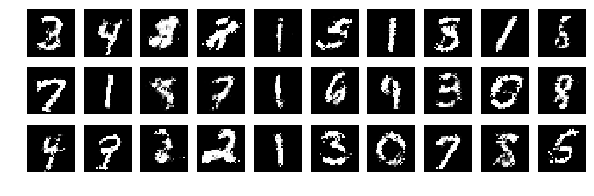

epoch: 95 	 last batch loss D: 11.18541145324707 	 last batch loss G: 12.554220199584961


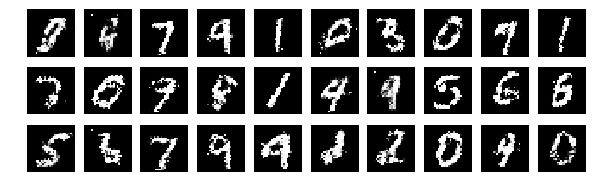

epoch: 96 	 last batch loss D: 9.063929557800293 	 last batch loss G: 9.648598670959473


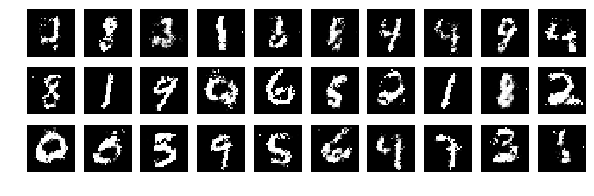

epoch: 97 	 last batch loss D: 8.422191619873047 	 last batch loss G: 10.89240837097168


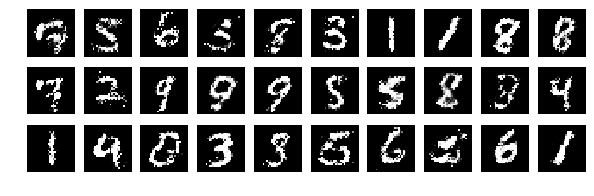

epoch: 98 	 last batch loss D: 8.138060569763184 	 last batch loss G: 11.611841201782227


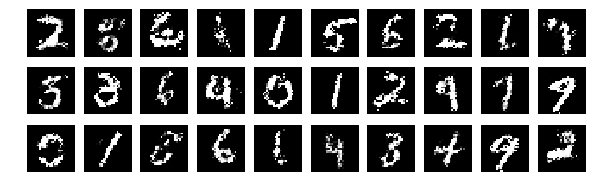

epoch: 99 	 last batch loss D: 10.60326099395752 	 last batch loss G: 14.542501449584961


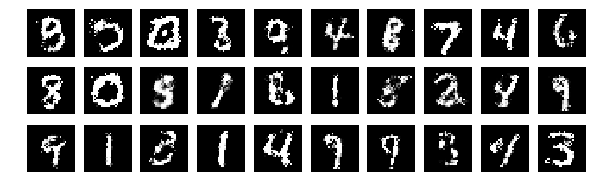

In [56]:
m = 16

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)

        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        z = torch.randn(img.shape[0], 128)
        if CUDA:
            z = z.cuda()
        fake_img = generator(z)

        # Discriminator Part
        opt_D.zero_grad()
        ########################## TODO ##########################
        # Define loss for discriminator
        real_image_discriminator=discriminator(real_img)["mse"]
        fake_image_discriminator=discriminator(fake_img.detach())["mse"]
        
        loss_d=(real_image_discriminator + torch.max(m-fake_image_discriminator,torch.zeros(real_image_discriminator.shape[0]).cuda())).mean(dim=(0))
        
        ######################## END TODO ########################
        loss_d.backward()
        opt_D.step()
        
        # Generator Part
        opt_G.zero_grad()
        ########################## TODO ##########################
        # Define loss for generator
        fake_image_discriminator=discriminator(fake_img)["mse"]
        loss_g=fake_image_discriminator.mean(dim=(0))
        ######################## END TODO ########################
        loss_g.backward()
        opt_G.step()
        

    
    print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))
    imgs_to_show = fake_img[:30].view(-1, 28, 28).detach().cpu().numpy()
    show(imgs_to_show, rows=3)
